# Simple Object Detector with Histogram of Oriented Gradients and Scikit-Learn

In [1]:
# ! unzip -q cat_faces.zip

In [2]:
# ! pip install --upgrade scikit-image
# ! pip install --upgrade imgauga

In [3]:
from skimage import data, color, feature, exposure, transform
import skimage.data
import matplotlib.pyplot as plt
from PIL import Image
import requests
import io
import glob
import numpy as np
from itertools import chain
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.image import PatchExtractor

from imgaug import augmenters as iaa

%matplotlib inline

## Visualize a sample image and the HOG features

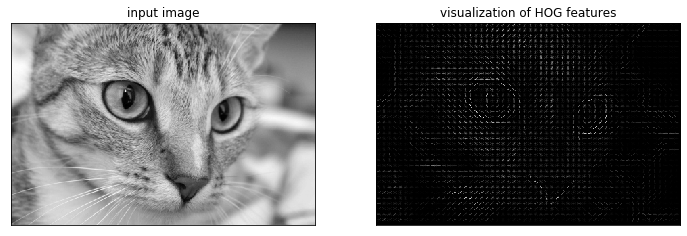

In [4]:
# Pull an image from the sklearn dataset
image = color.rgb2gray(data.chelsea())

# Featurize the image with Historgram of Oritented Gradients
hog_vec, hog_vis = feature.hog(image, visualize=True)

# Plot - 2 plots in one
fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

# Rescale histogram for better display
hog_vis_rescaled = exposure.rescale_intensity(hog_vis, in_range=(0, 10))

ax[1].imshow(hog_vis_rescaled, cmap='gray')
ax[1].set_title('visualization of HOG features');

In [5]:
data_array = []

# Get image files
img_files = glob.glob('cat_faces/*.*')

# Open each image with PIL, resize and convert to a numpy grayscale array
for img in img_files:
    im = Image.open(img)
    # Resize to uniform size
    im = im.resize((64, 64))
    # Convert to grayscale
    im = im.convert('L')
    im = np.asarray(im)
    data_array.append(im)

# Convert collection to numpy array
positive_patches = np.asarray(data_array)
positive_patches.shape

(10000, 64, 64)

In [6]:
imgs_to_use = ['astronaut',
           'binary_blobs',
           'camera',
           'checkerboard',
           'clock',
           'coffee',
           'coins',
           'horse',
           'hubble_deep_field',
           'immunohistochemistry',
           'logo',
           'moon',
           'page',
           'text',
           'retina',
           'rocket']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

In [7]:

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 250, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(12000, 64, 64)

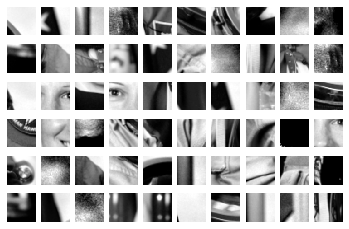

In [8]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[i], cmap='gray')
    axi.axis('off')

In [9]:
X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1
X_train.shape


(22000, 2916)

In [10]:
cross_val_score(GaussianNB(), X_train, y_train, cv=3)

array([0.86951186, 0.82285558, 0.82067367])

In [11]:
grid = GridSearchCV(LinearSVC(), {'C': [0.01, 0.05, 0.1, 0.5, 1.0, 2.0]}, cv=3)
grid.fit(X_train, y_train)
grid.best_score_

/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
 

0.9314540637882329

In [12]:
print(grid.best_params_)
# Assign model object to best performing model from grid search
model = grid.best_estimator_

{'C': 0.01}


In [13]:
# # URL to a sample image
# url = "https://raw.githubusercontent.com/pjreddie/darknet/master/data/dog.jpg"

# # HTTP GET request for an image from URL
# response = requests.get(url)

# # Check HTTP response is OK and throw error if not
# response.raise_for_status()

# # Get the image content
# with io.BytesIO(response.content) as f:
#     # Use PIL library to open image stream
#     with Image.open(f) as test_image:
#         # Display the image in Jupyer notebook
#         plt.imshow(test_image)
#         test_image = np.asarray(test_image)
# test_image = skimage.color.rgb2gray(test_image)
# test_image = skimage.transform.rescale(test_image, 0.5, multichannel=False)
# plt.imshow(test_image, cmap='gray')

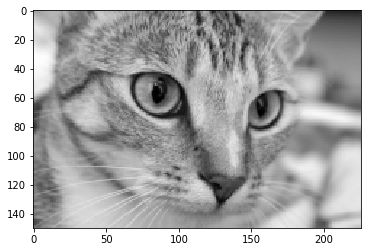

In [14]:
test_image = color.rgb2gray(data.chelsea())
test_image = skimage.transform.rescale(test_image, 0.5, multichannel=False)
plt.imshow(test_image, cmap='gray')

Sliding window and featurizing image may take some time.  The scale may need to be adjusted.

In [15]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch

print(test_image.shape)

# The bigger the scale, the bigger the box
scale = 2.0
indices, patches = zip(*sliding_window(test_image, scale=scale, istep=2, jstep=2))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(150, 226)


(539, 2916)

## Predict and visualize results
Predicting might take a few minutes.

In [16]:
labels = model.predict(patches_hog)
labels.sum()

171.0

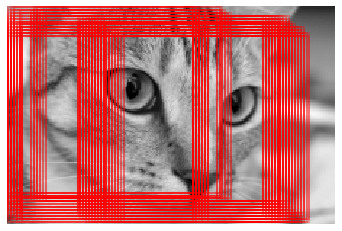

In [17]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = (positive_patches[0].shape[0] * scale), int(positive_patches[0].shape[1] * scale)
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))

## Image augmentation and retrain

Augment positive samples.

In [18]:
seq = iaa.Sequential([
    iaa.Fliplr(1.0), # horizontally flip all of the images
    iaa.LinearContrast((0.8, 1.2), per_channel=0.5)
])

images_aug_pos = seq.augment_images(positive_patches)

Augment negative samples as well.

In [19]:
seq = iaa.Sequential([
    iaa.Fliplr(1.0), # horizontally flip all of the images
    iaa.GaussianBlur(sigma=(0, 1.0)), # blur images with a sigma of 0 to 3.0
    iaa.LinearContrast((0.8, 1.2), per_channel=0.5)
])

images_aug_neg = seq.augment_images(negative_patches)

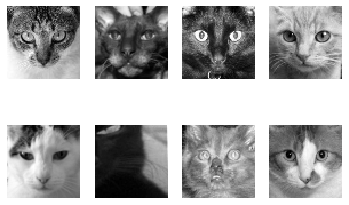

In [20]:
fig, ax = plt.subplots(2, 4)
for i, axi in enumerate(ax.flat):
    axi.imshow(positive_patches[i], cmap='gray')
    axi.axis('off')

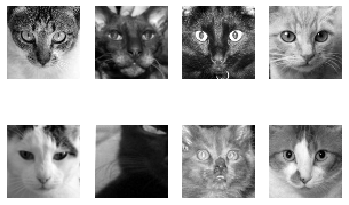

In [21]:
fig, ax = plt.subplots(2, 4)
for i, axi in enumerate(ax.flat):
    axi.imshow(images_aug_pos[i], cmap='gray')
    axi.axis('off')

In [22]:
positive_patches_aug = np.concatenate((positive_patches, images_aug_pos), axis=0)
positive_patches_aug.shape

(20000, 64, 64)

In [23]:
negative_patches_aug = np.concatenate((negative_patches, images_aug_neg), axis=0)
negative_patches_aug.shape

(24000, 64, 64)

In [24]:
X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches_aug,
                                    negative_patches_aug)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches_aug.shape[0]] = 1
X_train.shape

grid = GridSearchCV(LinearSVC(), {'C': [0.01, 0.05, 0.1, 0.5, 1.0, 2.0]}, cv=3)
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.best_params_)
# Assign model object to best performing model from grid search
model = grid.best_estimator_

/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.93802261873516
{'C': 0.05}


In [25]:
# Use test image again to predict with new model
labels = model.predict(patches_hog)
labels.sum()

146.0

In [ ]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = (positive_patches[0].shape[0] * scale), int(positive_patches[0].shape[1] * scale)
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='green',
                               alpha=0.3, lw=2, facecolor='none'))